In [2]:
import os
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from utils import load_model


# Device configuration
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Custom Dataset

In [3]:

class CustomImageDataset(Dataset):

    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_list = os.listdir(self.img_dir)
        img_path = os.path.join(self.img_dir, img_list[idx])
        image = read_image(img_path).float() / 255
        label = int(img_list[idx].split("_")[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Load Dataset and Model

In [4]:
model_names = ["resnet110_cifar100", 
               "preresnet164bn_cifar100", 
               "seresnet110_cifar100", 
               "densenet40_k36_bc_cifar100", 
               "diaresnet164bn_cifar100"
]


model = load_model(model_names, device)


clean_dataset = CustomImageDataset("./data/images")
clean_loader = DataLoader(dataset=clean_dataset, batch_size=100, shuffle=False)

attack_dataset = CustomImageDataset("./results")
attack_loader =  DataLoader(dataset=attack_dataset, batch_size=100, shuffle=False)

### Evaluation

In [5]:
total, correct = 0, 0

for images, labels in clean_loader:

    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(images)

    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()

print('Accuracy on the test images: {} %'.format(100 * correct / total))

Accuracy on the test images: 100.0 %


In [7]:
total, correct = 0, 0

for images, labels in attack_loader:

    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(images)

    _, prediction = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (prediction == labels).sum().item()

print('Accuracy on the test images: {} %'.format(100 * correct / total))

Accuracy on the test images: 18.6 %


Label: sea, Predicted: apple


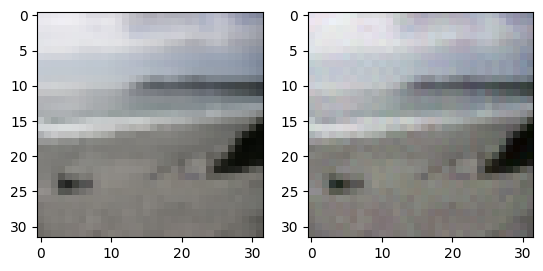

In [21]:
import random
from  mapping import true_labels
import matplotlib.pyplot as plt

n = random.randint(0, 499)


image = attack_dataset[n][0].to(device).reshape((1,3,32,32))
label = attack_dataset[n][1]

output = model(image)
_, prediction = torch.max(output.data, 1)

print(f"Label: {true_labels[label]}, Predicted: {true_labels[prediction[0]]}")

original_image = clean_dataset[n][0].numpy().transpose(1,2,0)
perturbed_image = attack_dataset[n][0].numpy().transpose(1,2,0)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image)
axarr[1].imshow(perturbed_image)
plt.show()